## Load Libraries & Prepare Data

In [1]:
#Load necessary libraries
import pandas as pd
import xarray as xr
import numpy as np 

from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from scipy.stats import linregress

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

In [2]:
#Load drought data
ds_drought_load = xr.open_dataset('/home/wpratt3/Clim680/Assignment2/pdsi.mon.mean.nc')
ds_drought_load

<xarray.Dataset> Size: 52MB
Dimensions:  (time: 1632, lat: 55, lon: 144)
Coordinates:
  * lon      (lon) float32 576B -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
  * lat      (lat) float32 220B -58.75 -56.25 -53.75 ... 71.25 73.75 76.25
  * time     (time) datetime64[ns] 13kB 1870-01-01 1870-02-01 ... 2005-12-01
Data variables:
    pdsi     (time, lat, lon) float32 52MB ...
Attributes:
    title:            Global Monthly Dai Palmer Drought Severity Index
    history:          recreated Feb 2007 from data at NCAR webpage
    References:       https://www.psl.noaa.gov/data/gridded/data.pdsi.html
    original_source:  NCAR/UCAR: A Dai.
    comments:         This version of the dataset (1870-2005) supersedes the ...
    Conventions:      COARDS
    details:          see ncar for more detials and updates\nhttp://www.cgd.u...
    dataset_title:    Palmer Drought Severity Index

In [3]:
#Load soils data, subset time to drought, subset lat/lon to continental US
ds_soil_load = xr.open_dataset('/home/wpratt3/Clim680/Data/soilw.mon.mean.v2.nc.1')
ds_soil_reversed = ds_soil_load.reindex(lat=list(reversed(ds_soil_load['lat'])))
ds_soil_reversed_time = ds_soil_reversed.sel(time=slice(ds_drought_load['time'][0],ds_drought_load['time'][-1]))
ds_soil = ds_soil_reversed_time.soilw.sel(lon=slice(360-125,360-65), lat=slice(23.75,48.75))
ds_soil

<xarray.DataArray 'soilw' (time: 696, lat: 51, lon: 120)> Size: 17MB
[4259520 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 204B 23.75 24.25 24.75 25.25 ... 47.75 48.25 48.75
  * lon      (lon) float32 480B 235.2 235.8 236.2 236.8 ... 293.8 294.2 294.8
  * time     (time) datetime64[ns] 6kB 1948-01-01 1948-02-01 ... 2005-12-01
Attributes:
    long_name:      Model-Calculated Monthly Mean Soil Moisture
    units:          mm
    valid_range:    [   0. 1000.]
    dataset:        CPC Monthly Soil Moisture
    var_desc:       Soil Moisture
    level_desc:     Surface
    statistic:      Monthly Mean
    parent_stat:    Other
    standard_name:  lwe_thickness_of_soil_moisture_content
    cell_methods:   time: mean (monthly from values)
    actual_range:   [  0.     756.0375]

In [4]:
#Subset drought time to soil time, subset lat/lon to continental US
ds_drought_time = ds_drought_load.sel(time=slice(ds_soil['time'][0],ds_soil['time'][-1]))
#Need to interpolate to soil scale
ds_drought = ds_drought_time.sel(lon=slice(-125,-65), lat=slice(23.75,48.75))
ds_drought

<xarray.Dataset> Size: 741kB
Dimensions:  (time: 696, lat: 11, lon: 24)
Coordinates:
  * lon      (lon) float32 96B -123.8 -121.2 -118.8 ... -71.25 -68.75 -66.25
  * lat      (lat) float32 44B 23.75 26.25 28.75 31.25 ... 43.75 46.25 48.75
  * time     (time) datetime64[ns] 6kB 1948-01-01 1948-02-01 ... 2005-12-01
Data variables:
    pdsi     (time, lat, lon) float32 735kB ...
Attributes:
    title:            Global Monthly Dai Palmer Drought Severity Index
    history:          recreated Feb 2007 from data at NCAR webpage
    References:       https://www.psl.noaa.gov/data/gridded/data.pdsi.html
    original_source:  NCAR/UCAR: A Dai.
    comments:         This version of the dataset (1870-2005) supersedes the ...
    Conventions:      COARDS
    details:          see ncar for more detials and updates\nhttp://www.cgd.u...
    dataset_title:    Palmer Drought Severity Index

## Calculate Climatology, Anomaly, and Drought Index

In [5]:
#Drought climatology & anomalies
da_drought_clim = ds_drought['pdsi'].groupby('time.month').mean(dim='time')
da_drought_anom = ds_drought['pdsi'].groupby('time.month')-da_drought_clim
ds_drought_anom = ds_drought.groupby('time.month')-da_drought_clim


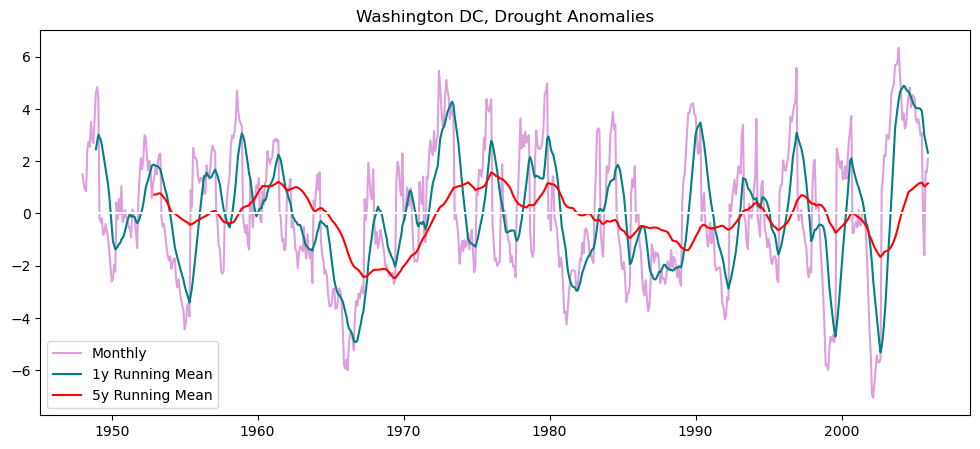

In [6]:
#Plot drought index in DC across time
da_drought_anom_pt = da_drought_anom.sel(lat=39,lon=-77,method='nearest')
da_drought_smooth_1y = da_drought_anom_pt.rolling(time=12).mean()
da_drought_smooth_5y = da_drought_anom_pt.rolling(time=60).mean()

fig = plt.figure(figsize=(12,5))
plt.plot(da_drought_anom_pt['time'],da_drought_anom_pt, label = 'Monthly', c='plum')
plt.plot(da_drought_smooth_1y['time'],da_drought_smooth_1y,label='1y Running Mean',c='teal')
plt.plot(da_drought_smooth_5y['time'],da_drought_smooth_5y,label='5y Running Mean',c='red')
plt.title('Washington DC, Drought Anomalies')
plt.axhline(y=0,c='white')
plt.legend()

In [7]:
ds_drought_anom_index = ds_drought_anom.mean(dim=['lat','lon'])
ds_drought_anom_index

<xarray.Dataset> Size: 14kB
Dimensions:  (time: 696)
Coordinates:
  * time     (time) datetime64[ns] 6kB 1948-01-01 1948-02-01 ... 2005-12-01
    month    (time) int64 6kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    pdsi     (time) float32 3kB -0.4754 -0.1394 0.1863 ... -0.06965 -0.2037

In [8]:
#When cleaning code, change the code to the select pdsi variable out of dataset instead of array
da_drought_anom_index = da_drought_anom.mean(dim=['lat','lon'])
da_drought_anom_index

<xarray.DataArray 'pdsi' (time: 696)> Size: 3kB
array([-4.75376159e-01, -1.39377370e-01,  1.86251685e-01, -4.21531387e-02,
       -9.93482247e-02,  1.74814865e-01,  2.36768723e-01, -1.98605716e-01,
       -5.26757956e-01, -6.66281521e-01, -3.01286697e-01, -8.30096975e-02,
        5.40668249e-01,  6.80804729e-01,  4.95051384e-01,  6.54853955e-02,
        5.61286211e-02,  2.14674667e-01,  3.18036079e-02, -2.90257841e-01,
       -3.52031082e-01, -2.13299438e-01, -9.53807771e-01, -7.65172541e-01,
       -7.32953176e-02, -8.58290121e-02,  5.51847601e-03,  1.19570894e-02,
       -3.64621282e-02,  1.30708173e-01,  6.75239146e-01,  3.66585582e-01,
        4.01586443e-01, -7.78490528e-02,  7.84947872e-02, -2.72743311e-02,
        1.53905554e-02,  2.08241060e-01,  2.43770763e-01,  1.58752918e-01,
       -2.82764047e-01, -1.43265486e-01, -2.13580608e-01,  7.74636269e-02,
        6.30200729e-02,  4.42483515e-01,  6.23259008e-01,  9.75750446e-01,
        9.21731949e-01,  7.97745049e-01,  9.17945921e-01,  3.75902086e-01,
        7.74880648e-02, -1.35419428e-01, -2.26580143e-01, -3.81436348e-01,
       -1.02619445e+00, -1.71870553e+00, -1.53626204e+00, -1.35858977e+00,
       -9.78796780e-01, -7.06891060e-01, -5.74896276e-01, -1.95399746e-01,
       -2.55795717e-01, -5.93808949e-01, -6.43240452e-01, -7.83291161e-01,
       -1.41710436e+00, -1.75523269e+00, -2.00597072e+00, -1.72022760e+00,
       -1.58742177e+00, -1.71006393e+00, -1.43063641e+00, -1.29959404e+00,
       -1.25671971e+00, -1.25957191e+00, -1.45571852e+00, -1.32973111e+00,
...
       -3.12433630e-01, -1.01269686e+00, -1.61000979e+00, -1.86228168e+00,
       -1.97348881e+00, -1.92413712e+00, -1.92085803e+00, -1.75031292e+00,
       -1.50368786e+00, -1.06088150e+00, -1.19533634e+00, -1.29468501e+00,
       -1.23615050e+00, -5.23328185e-01, -1.82350993e-01, -4.34627652e-01,
       -6.39756739e-01, -5.58349133e-01, -5.01603067e-01, -5.84055901e-01,
       -7.16872692e-01, -8.41329336e-01, -9.38500702e-01, -1.35203922e+00,
       -1.45493567e+00, -1.42976272e+00, -1.46959722e+00, -1.57448900e+00,
       -1.87383604e+00, -2.05070806e+00, -1.91544473e+00, -1.95733225e+00,
       -1.96088541e+00, -2.10332298e+00, -2.42458963e+00, -2.51070976e+00,
       -2.25670266e+00, -1.72157288e+00, -1.94388390e+00, -1.74173391e+00,
       -2.21986127e+00, -1.88114882e+00, -1.82594550e+00, -1.49311924e+00,
       -1.28946626e+00, -1.23326600e+00, -1.44824791e+00, -1.70718384e+00,
       -1.44147110e+00, -1.46982527e+00, -1.34469044e+00, -1.34495544e+00,
       -1.51044369e+00, -1.29883230e+00, -1.58651984e+00, -1.40439761e+00,
       -8.97324979e-01, -5.23049533e-01, -5.46030819e-01, -2.84401089e-01,
       -1.98974177e-01,  4.87782389e-01,  7.95509815e-01,  7.23272264e-01,
        7.13341773e-01,  5.21471083e-01,  3.00844997e-01,  3.94425303e-01,
        4.64547843e-01,  5.50535738e-01,  2.58057326e-01,  3.60414356e-01,
       -1.16128184e-01,  5.69610782e-02, -6.96468726e-02, -2.03709438e-01],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 6kB 1948-01-01 1948-02-01 ... 2005-12-01
    month    (time) int64 6kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

In [9]:
#Assign 3 index categories
moist = da_drought_anom_index.where(da_drought_anom_index>=0.5) # nans where false and unaltered where true if only first parameter given
drought = da_drought_anom_index.where(da_drought_anom_index<=-0.5)
neutral = da_drought_anom_index.where((da_drought_anom_index>-0.5) & (da_drought_anom_index<0.5))

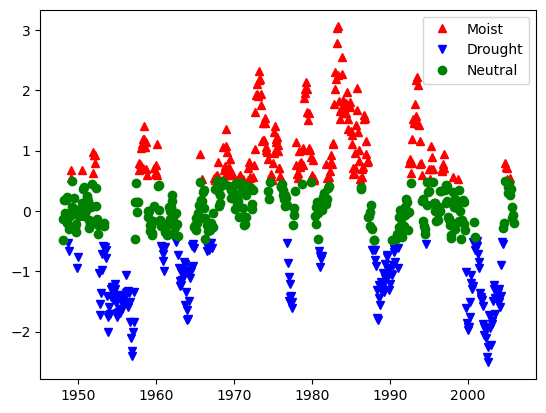

In [10]:
#Plot categorized drought over time
plt.plot(da_drought_anom_index['time'],moist, marker = '^', color = 'red', linestyle = 'none', label = 'Moist')
plt.plot(da_drought_anom_index['time'],drought,'bv', label = 'Drought')
plt.plot(da_drought_anom_index['time'],neutral,'go', label = 'Neutral')

plt.legend()

In [11]:
#Calculate and prepare counts of observations in each drought index category
print('Moist: ',moist.count(dim='time').values)
print('Drought: ',drought.count(dim='time').values)
print('Neutral: ',neutral.count(dim='time').values)

counts=[moist.count(dim='time').values,
        drought.count(dim='time').values,
        neutral.count(dim='time').values]

print(counts)

Moist:  220
Drought:  201
Neutral:  275
[array(220), array(201), array(275)]


In [12]:
#Calculate climatology and anomalies of soils data
ds_soil_climo = ds_soil.groupby('time.month').mean()
ds_soil_anoms = ds_soil.groupby('time.month')-ds_soil_climo
ds_soil_anoms

<xarray.DataArray 'soilw' (time: 696, lat: 51, lon: 120)> Size: 17MB
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-7.60015869e+00, -2.66296387e+00, -6.06842041e+00, ...,
         -5.95142517e+01, -2.90377197e+01,  2.29675903e+01],
        [-1.95059814e+01, -1.03151855e+01, -6.37414551e+00, ...,
         -6.66376953e+01, -3.78570862e+01, -5.47244263e+00],
        [-1.41181030e+01, -3.34880981e+01, -3.87192993e+01, ...,
         -5.14708557e+01, -4.67809143e+01, -3.91775208e+01]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
          8.21776123e+01,  6.16386414e+01,  6.26352844e+01],
        [ 3.39318848e+01,  3.52045898e+01,  6.33205566e+01, ...,
          7.78151855e+01,  7.26597290e+01,  7.05255737e+01],
        [-2.14732056e+01,  1.05853577e+01,  6.73711853e+01, ...,
          4.73649292e+01,  4.95530701e+01,  5.99574280e+01]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-2.25018311e+00, -1.87988281e-02,  6.03802490e+00, ...,
          1.10929596e+02,  9.27438354e+01,  9.11771240e+01],
        [-1.51446533e+00,  2.48632812e+00,  3.71580811e+01, ...,
          9.63305359e+01,  9.19802856e+01,  9.03969421e+01],
        [-3.51346436e+01, -3.12280273e+01,  2.01410522e+01, ...,
          6.09700928e+01,  7.17897644e+01,  8.83453369e+01]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 204B 23.75 24.25 24.75 25.25 ... 47.75 48.25 48.75
  * lon      (lon) float32 480B 235.2 235.8 236.2 236.8 ... 293.8 294.2 294.8
  * time     (time) datetime64[ns] 6kB 1948-01-01 1948-02-01 ... 2005-12-01
    month    (time) int64 6kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

In [13]:
dc_soil = ds_soil_anoms.sel(lat=39,lon=360-77, method='nearest')
dc_soil

<xarray.DataArray 'soilw' (time: 696)> Size: 3kB
array([ 9.24652405e+01,  8.98037109e+01,  6.30955200e+01,  4.48217773e+01,
        6.15087891e+01,  9.03873901e+01,  7.53265076e+01,  7.43278198e+01,
        6.12495728e+01,  3.90502319e+01,  5.92027893e+01,  8.94638672e+01,
        1.12850616e+02,  1.08844971e+02,  7.08151855e+01,  4.17930908e+01,
        4.25653076e+01,  2.25237427e+01,  1.20370178e+01,  1.20802307e+01,
       -4.37988281e-01, -2.51458740e+00, -2.31981201e+01, -4.75847473e+01,
       -6.41898193e+01, -6.05675659e+01, -2.99871826e+01, -2.65901489e+01,
       -1.68080444e+01,  4.44677734e+00,  1.12341003e+01,  6.63751221e+00,
        6.32099609e+01,  1.02299316e+02,  8.16419067e+01,  6.99171753e+01,
        5.34391174e+01,  4.45791626e+01,  2.76390381e+01,  1.52413940e+01,
        4.47296143e+00,  4.31596069e+01,  5.68294983e+01,  1.33540039e+01,
       -1.85494080e+01, -4.27703247e+01, -1.60447998e+01,  4.59720764e+01,
        7.83359070e+01,  6.66486206e+01,  5.45212402e+01,  8.86603394e+01,
        1.09957458e+02,  8.49993286e+01,  4.84525452e+01,  5.58453064e+01,
        7.80975037e+01,  5.39516602e+01,  6.83911438e+01,  8.92280884e+01,
        8.17687073e+01,  7.23687744e+01,  7.17902222e+01,  7.37855835e+01,
        7.26858521e+01,  5.22310181e+01,  2.07514038e+01,  6.31433105e+00,
        7.53649902e+00,  1.01596375e+01, -7.92376709e+00, -1.41808472e+01,
       -1.59559937e+01, -4.31415405e+01, -4.93966064e+01, -3.40838928e+01,
       -3.01661682e+01, -5.42052917e+01, -7.59959106e+01, -6.21689453e+01,
...
        4.31615906e+01,  1.03608948e+02,  6.47604980e+01,  3.26218567e+01,
        2.28433533e+01,  1.48576050e+01,  4.33001709e+00,  1.21478271e+01,
        6.92810059e+00,  8.25134277e-01,  2.65543213e+01,  2.99589539e+01,
        3.77732239e+01,  6.55667114e+00, -3.43990784e+01, -5.00704651e+01,
       -5.37226257e+01, -6.12055054e+01, -4.92993774e+01, -4.63293762e+01,
       -4.48942261e+01, -1.95895081e+01, -1.01190491e+01, -1.90745239e+01,
       -3.67252808e+01, -7.23634949e+01, -1.08217163e+02, -1.36128937e+02,
       -1.53940186e+02, -1.79421326e+02, -1.82826538e+02, -1.53839844e+02,
       -1.28249359e+02, -1.17042023e+02, -1.15818298e+02, -1.10119934e+02,
       -9.65220032e+01, -4.24257202e+01,  1.23387451e+01,  4.34135742e+01,
        5.18075867e+01,  7.54401855e+01,  8.88551636e+01,  6.52114868e+01,
        6.91176147e+01,  1.02263733e+02,  1.11649231e+02,  8.78874207e+01,
        1.00885193e+02,  1.32230347e+02,  1.35791260e+02,  1.33249451e+02,
        1.03789337e+02,  6.72850342e+01,  3.27786255e+01,  2.80688477e+01,
        2.49979858e+01,  2.63486023e+01,  5.34274597e+01,  5.60574646e+01,
        4.91140137e+01,  2.29490051e+01,  2.63299561e+00, -3.93371582e-01,
       -8.53729248e-01, -1.31302185e+01, -1.00379028e+01,  8.57690430e+00,
        8.92864990e+00,  2.13754272e+00,  2.10670776e+01,  1.24452820e+01,
       -6.11201172e+01, -2.50982971e+01,  2.02873230e+01,  7.03112793e+00],
      dtype=float32)
Coordinates:
    lat      float32 4B 39.25
    lon      float32 4B 283.2
  * time     (time) datetime64[ns] 6kB 1948-01-01 1948-02-01 ... 2005-12-01
    month    (time) int64 6kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

Text(0, 0.5, 'Palmer Drought Severity Index')

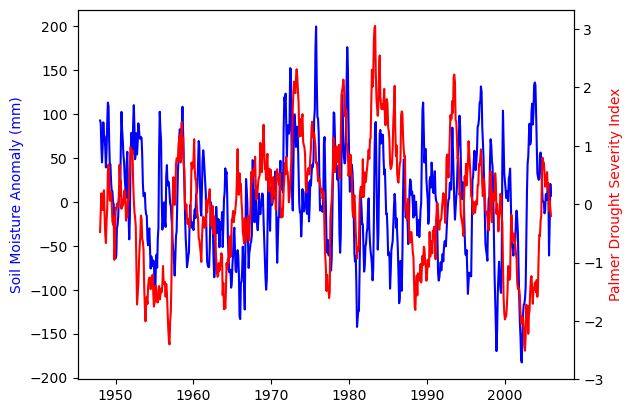

In [14]:
#Plot soil moisture & PDSI across time in DC
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(dc_soil['time'], dc_soil, color = 'b')
ax2.plot(ds_drought_anom_index['time'], ds_drought_anom_index['pdsi'], color = 'r')

ax1.set_yticks(range(-200,201,50))
ax2.set_yticks(range(-3,4,1))

ax1.set_ylabel('Soil Moisture Anomaly (mm)', color='b')
ax2.set_ylabel('Palmer Drought Severity Index', color='r') 

## Composite Analysis of Soil Moisture based on PDSI Index

In [15]:
#Select data from soil moisture anomalies based on periods of arctic oscillation cycles
moist_soil = ds_soil_anoms.sel(time=moist.dropna(dim='time')['time']).mean(dim='time')
drought_soil = ds_soil_anoms.sel(time=drought.dropna(dim='time')['time']).mean(dim='time')
neutral_soil = ds_soil_anoms.sel(time=neutral.dropna(dim='time')['time']).mean(dim='time')

comp_soil = [moist_soil, drought_soil, neutral_soil]
neutral_soil

<xarray.DataArray 'soilw' (lat: 51, lon: 120)> Size: 24kB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [ 2.0380242,  4.8640795,  4.463189 , ..., -9.3822975, -9.2347765,
        -6.4280243],
       [ 4.472889 ,  5.1274896,  8.810456 , ..., -8.059924 , -2.9229777,
         1.5785564],
       [ 2.371475 ,  5.0676503,  7.3680124, ..., -7.642743 , -5.296606 ,
        -2.2862957]], dtype=float32)
Coordinates:
  * lat      (lat) float32 204B 23.75 24.25 24.75 25.25 ... 47.75 48.25 48.75
  * lon      (lon) float32 480B 235.2 235.8 236.2 236.8 ... 293.8 294.2 294.8

Text(0.5, 0.95, 'Composite Soil Moisture Anomalies during Palmer Drought Severity Cycles')

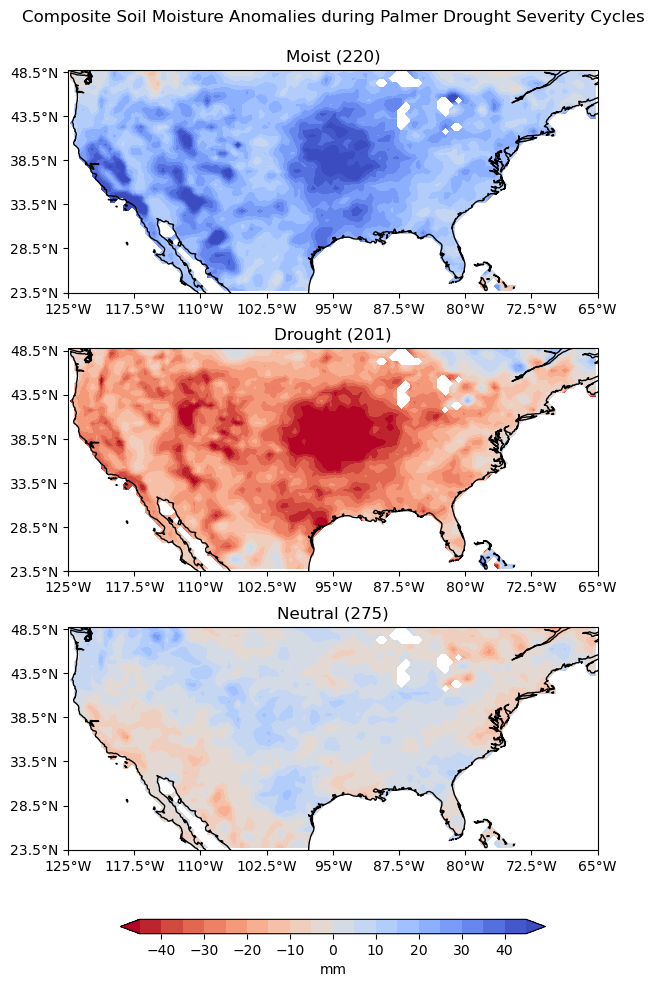

In [16]:
#Create plot of soil moisture anomalies during different PDSI cycles
labels=['Moist','Drought', 'Neutral']
clevs = np.arange(-45.0,45.1,5)

# Define the figure and each axis for the 3 rows and 1 column
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,12))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the seasons and plot
for i,pdsi in enumerate(comp_soil):

        # Select the season
        data = comp_soil[i]

        # Contour plot
        cs=axs[i].contourf(comp_soil[i]['lon'],comp_soil[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='coolwarm_r',
                          extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-125,-60,7.5), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(23.5,53.5,5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Title each subplot with the name of the arctic oscillation period
        axs[i].set_title(labels[i]+' ('+str(counts[i])+')')

        axs[i].coastlines()
        
# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.25)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', label='mm')

# Add a big title at the top
plt.suptitle('Composite Soil Moisture Anomalies during Palmer Drought Severity Cycles', y= .95) 

In [17]:
#Calculate differences of positive and negative cycle from neutral
diff_soil =[moist_soil-neutral_soil, 
             drought_soil-neutral_soil]

diff_soil

[<xarray.DataArray 'soilw' (lat: 51, lon: 120)> Size: 24kB
 array([[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [ -4.398857  ,  -6.1379614 ,  -0.46611142, ...,  17.883793  ,
          12.466442  ,   5.1035132 ],
        [-10.44022   ,  -9.392852  , -11.031649  , ...,  16.929464  ,
           4.985829  ,  -5.2731194 ],
        [  2.4408138 ,  -3.2785192 , -11.776722  , ...,  13.266331  ,
           6.210038  ,  -1.4273827 ]], dtype=float32)
 Coordinates:
   * lat      (lat) float32 204B 23.75 24.25 24.75 25.25 ... 47.75 48.25 48.75
   * lon      (lon) float32 480B 235.2 235.8 236.2 236.8 ... 293.8 294.2 294.8,
 <xarray.DataArray 'soilw' (lat: 51, lon: 120)> Size: 24kB
 array([[         nan,          

Text(0.5, 0.95, 'Composite Soil Moisture Anomaly Differences during Palmer Drought Severity Cycles')

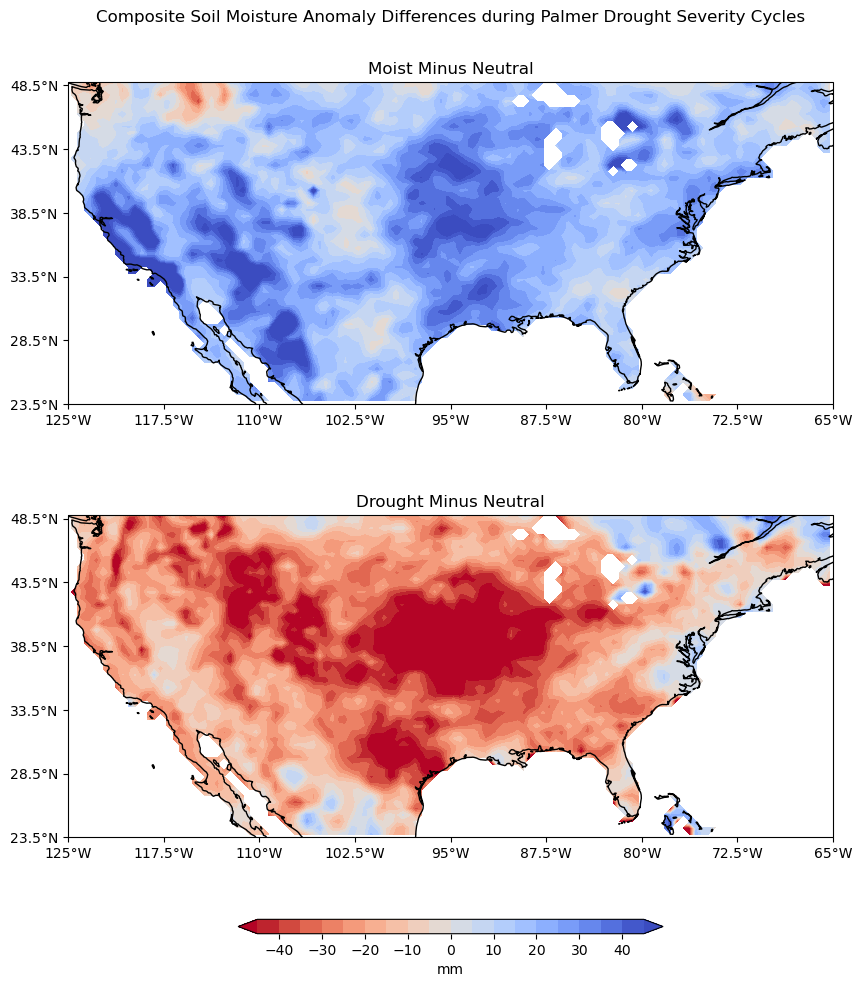

In [18]:
#Create plot of soil moisture anomalies during different PDSI cycles
labels=['Moist Minus Neutral','Drought Minus Neutral']
clevs = np.arange(-45.0,45.1,5)

# Define the figure and each axis for the 2 rows and 1 column
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,12))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the seasons and plot
for i,pdsi in enumerate(diff_soil):

        # Select the season
        data = diff_soil[i]

        # Contour plot
        cs=axs[i].contourf(diff_soil[i]['lon'],diff_soil[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='coolwarm_r',
                          extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-125,-60,7.5), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(23.5,53.5,5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Title each subplot with the name of the arctic oscillation period
        axs[i].set_title(labels[i])

        axs[i].coastlines()
        
# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.25)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', label='mm')

# Add a big title at the top
plt.suptitle('Composite Soil Moisture Anomaly Differences during Palmer Drought Severity Cycles', y= .95) 

In [19]:
#Set the p value for our test and select values for test based on cycle
p = 0.05

moist_soil_vals = ds_soil_anoms.sel(time=moist.dropna(dim='time')['time'])
drought_soil_vals = ds_soil_anoms.sel(time=drought.dropna(dim='time')['time'])
neutral_soil_vals = ds_soil_anoms.sel(time=neutral.dropna(dim='time')['time'])

In [20]:
#Test for significant differences for moist and drought cycle from the neutral
moist_tstat,moist_pval = ttest_ind(moist_soil_vals, 
                neutral_soil_vals, 
                equal_var = False)

drought_tstat,drought_pval = ttest_ind(drought_soil_vals, 
                neutral_soil_vals, 
                equal_var = False)

In [21]:
#Create mask of differences in soil that were significant
moist_mask_diff = diff_soil[0].where(moist_pval <= p)
drought_mask_diff = diff_soil[1].where(drought_pval <= p)

mask_diff = [moist_mask_diff, drought_mask_diff]

Text(0.5, 0.98, 'Significant Soil Moisture Anomaly Differences in\nOn Minus Off Palmer Drought Severity Cycle')

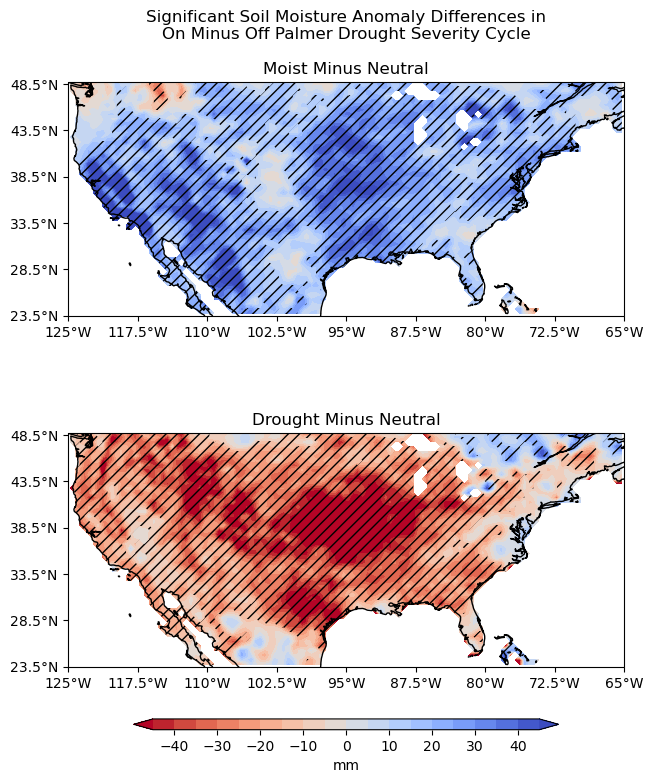

In [22]:
#Plot areas of significant difference for both moist and drought cycles using a symbol
labels=['Moist Minus Neutral','Drought Minus Neutral']
clevs=np.arange(-45,45.1,5)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,9))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs = axs.flatten()

#Loop over all of the periods and plot
for i,pdsi in enumerate(diff_soil):

        # Select the season
        data = diff_soil[i]

        # Contour plot
        cs = axs[i].contourf(diff_soil[i]['lon'],diff_soil[i]['lat'],data,clevs,
                          transform=ccrs.PlateCarree(),
                          cmap='coolwarm_r',
                          extend='both')
        
        # Overlay of slashes
        ss = axs[i].contourf(diff_soil[i]['lon'],diff_soil[i]['lat'],mask_diff[i],[0,1],
                transform = ccrs.PlateCarree(),
                colors = ['None'],
                hatches = ['///',''],
                extend = 'both',
                alpha = 0.0)

       # Longitude labels
        axs[i].set_xticks(np.arange(-125,-60,7.5), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(23.5,53.5,5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Title each subplot with the name of the period difference
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax,
                orientation='horizontal',
                label='mm')

# Add a big title at the top
plt.suptitle('Significant Soil Moisture Anomaly Differences in\nOn Minus Off Palmer Drought Severity Cycle')

## Correlation Analysis of Soil Moisture and PDSI

In [23]:
r_map = xr.corr(ds_drought_anom_index['pdsi'], ds_soil_anoms, dim='time')
r_map

/home/wpratt3/miniforge/envs/climate/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/wpratt3/miniforge/envs/climate/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<xarray.DataArray (lat: 51, lon: 120)> Size: 24kB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.01092693,  0.0547866 ,  0.1452673 , ...,  0.09385493,
         0.02743406, -0.01716843],
       [-0.04516002, -0.00766118,  0.04284137, ...,  0.09955703,
         0.05642141, -0.00730409],
       [ 0.08370925,  0.08063027,  0.01587884, ...,  0.05352755,
         0.00524237, -0.04333916]], dtype=float32)
Coordinates:
  * lat      (lat) float32 204B 23.75 24.25 24.75 25.25 ... 47.75 48.25 48.75
  * lon      (lon) float32 480B 235.2 235.8 236.2 236.8 ... 293.8 294.2 294.8

Text(0.5, 1.0, 'Correlation between Palmer Drought Severity Index and Soil Moisture Anomalies')

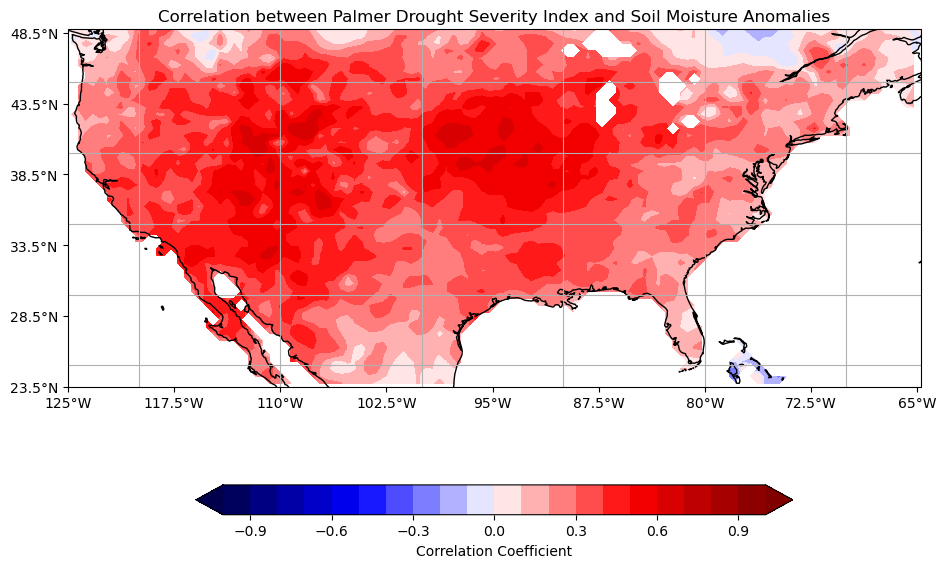

In [24]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())

# Add cyclic point
data=r_map
data,lon=add_cyclic_point(r_map,coord=ds_soil_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,ds_soil_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='seismic',extend='both')

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

#label_latlon(ax,np.arange(-180,181,60),np.arange(-90,91,30))
# Define the xticks for longtitude 
ax.set_xticks(np.arange(-125,-60,7.5),crs=ccrs.PlateCarree())
lon_formatter=cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
ax.set_yticks(np.arange(23.5,53.5,5),crs=ccrs.PlateCarree())
lat_formatter=cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between Palmer Drought Severity Index and Soil Moisture Anomalies')

In [25]:
#Test for significance of correlation
nx=len(ds_soil_anoms['lon'])
ny=len(ds_soil_anoms['lat'])

p_array_corr=np.zeros((ny,nx))
r_array_corr=np.zeros((ny,nx))

for i in range(nx):
    for j in range(ny):
        r,p = pearsonr(ds_drought_anom_index['pdsi'],ds_soil_anoms[:,j,i])
        r_array_corr[j,i] = r
        p_array_corr[j,i] = p

In [26]:
#Use p-value .01 to create mask
mask_sig_corr = np.where(p_array_corr<0.005, r_array_corr, np.nan)

Text(0.5, 1.0, 'Correlation between Palmer Drought Severity Index and Soil Moisture Anomalies')

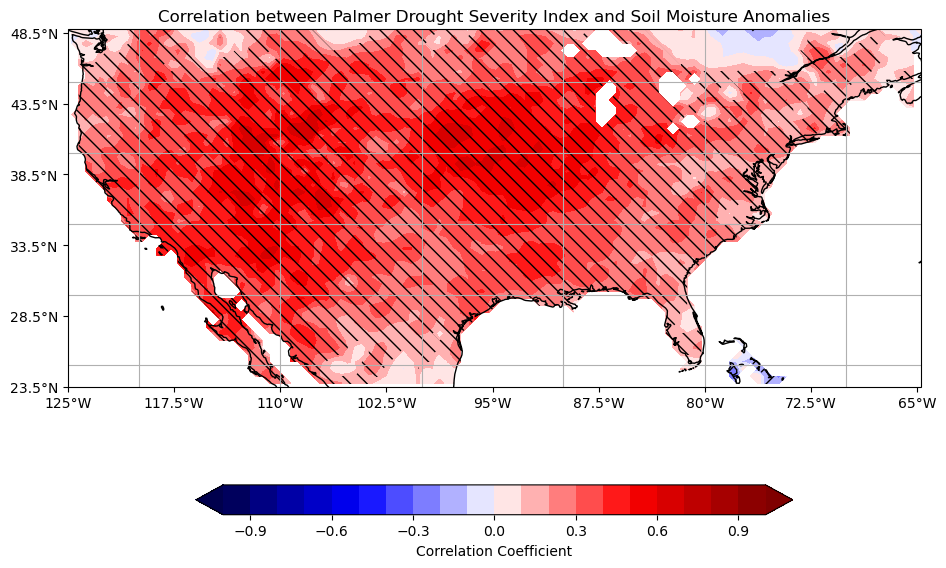

In [27]:
#Map significant correlation
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())

# Add cyclic point
data=r_map
data,lon=add_cyclic_point(r_map,coord=ds_soil_anoms['lon'])
mask_data_corr,lons=add_cyclic_point(mask_sig_corr,coord=ds_soil_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,ds_soil_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='seismic',extend='both')

ax.contourf(lon,ds_soil_anoms['lat'],mask_data_corr,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['//','\\\\'],extend='both',alpha=0)

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

#label_latlon(ax,np.arange(-180,181,60),np.arange(-90,91,30))
# Define the xticks for longtitude 
ax.set_xticks(np.arange(-125,-60,7.5),crs=ccrs.PlateCarree())
lon_formatter=cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
ax.set_yticks(np.arange(23.5,53.5,5),crs=ccrs.PlateCarree())
lat_formatter=cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between Palmer Drought Severity Index and Soil Moisture Anomalies')

## Linear Regression Analysis of Soil Moisture Dependent on PDSI

In [28]:
p_array_linr = np.zeros((ny,nx))   # The p-value (significance) of the fit of the regression
r_array_linr = np.zeros((ny,nx))   # The correlation between the independent and dependent variables
m_array_linr = np.zeros((ny,nx))   # The slope of the best-fit linear regression line

x =       ds_drought_anom_index['pdsi']    # The independent variable (predictor)

#### Loop through all the grid cells in the global grid
for j in range(ny):
    print(f"{j},",end=" ")
    for i in range(nx):
        #Precip data dimensions are ordered as (time, lat, lon)
        y = ds_soil_anoms[:,j,i] # The dependent variable (predictand)
        
        m,b,r,p,e = linregress(x,y)   # b is intercept, e is tuple of standard error & intercept error
        
        # Populate our new arrays with the results
        m_array_linr[j,i] = m
        r_array_linr[j,i] = r
        p_array_linr[j,i] = p
print("*** DONE ***")

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, *** DONE ***


In [29]:
#Create mask of significant regression points
mask_sig_linr = np.where(p_array_linr<0.001, m_array_linr, np.nan)

Text(0.5, 1.0, 'Regression between Palmer Drought Severity Index and Soil Moisture Anomalies')

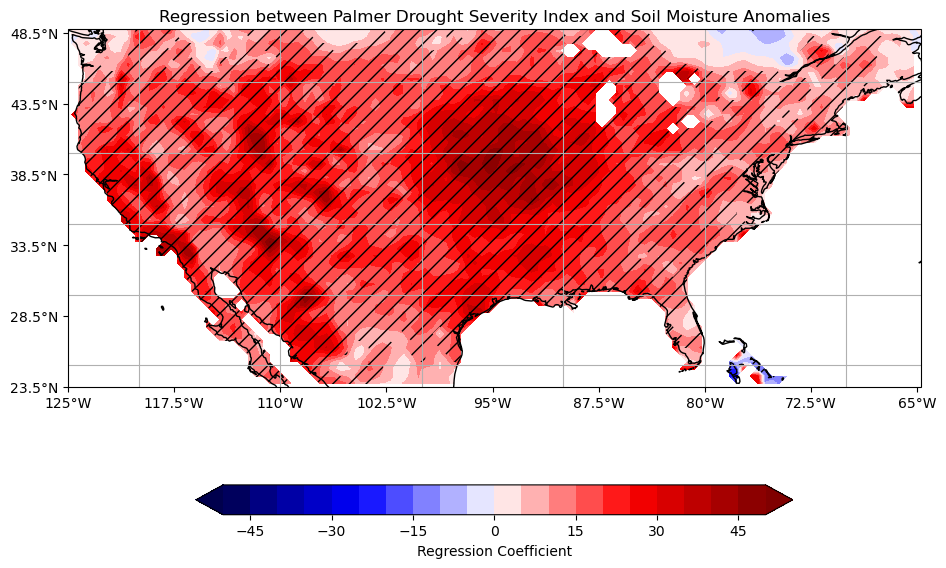

In [30]:
#Map significant regression
clevs=np.arange(-50,55,5)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())

# Add cyclic point
data=m_array_linr
data,lon=add_cyclic_point(m_array_linr,coord=ds_soil_anoms['lon'])
mask_data_linr,lons=add_cyclic_point(mask_sig_linr,coord=ds_soil_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,ds_soil_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='seismic',extend='both')

ax.contourf(lon,ds_soil_anoms['lat'],mask_data_linr,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['//','\\\\'],extend='both',alpha=0)

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

#label_latlon(ax,np.arange(-180,181,60),np.arange(-90,91,30))
# Define the xticks for longtitude 
ax.set_xticks(np.arange(-125,-60,7.5),crs=ccrs.PlateCarree())
lon_formatter=cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
ax.set_yticks(np.arange(23.5,53.5,5),crs=ccrs.PlateCarree())
lat_formatter=cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Regression Coefficient')

# Add title
plt.title('Regression between Palmer Drought Severity Index and Soil Moisture Anomalies')